In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter

#import the necessary libraries 
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

### III. Models and calibration

### III.1. Spatial interaction models:

In [2]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [3]:
import pandas as pd
flows = pd.read_csv("london_flows.csv")
flows['log_dist'] = np.log(flows['distance'] + 0.01)
flows['log_population'] = np.log(flows['population'] + 0.01)
flows['log_jobs'] = np.log(flows['jobs'] + 1)
flows.head(10)
flows_c = flows.copy()
flows10 = flows.copy()
flows11 = flows.copy()

In [4]:
flows

,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003505,6.395278,11.271491
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049013,6.395278,6.093570
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236277,6.395278,6.501290
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981438
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709278,6.395278,9.644004
...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795550,9.503145,8.973606,8.114624
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071247,8.973606,8.610319
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162906,8.973606,5.993961
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585834,8.973606,6.795706


### Total constrained

In [5]:
formula = 'flows ~ log_population + log_jobs + log_dist'

#run the regression
uncosim = smf.glm(formula = formula, 
                  data=flows, 
                  family=sm.families.Poisson()).fit()

print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    61470
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4298e+06
Date:                Mon, 09 May 2022   Deviance:                   2.6874e+06
Time:                        23:45:33   Pearson chi2:                 6.30e+06
No. Iterations:                    14   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -8.9990      0.011   -838.

In [6]:
flows["uncosimfitted"] = np.round(uncosim.mu)

flows_tab1 = flows.pivot_table(values ="uncosimfitted", 
                               index="station_origin", 
                               columns = "station_destination",
                               aggfunc=np.sum, margins=True)
flows_tab1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,215.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,347.0
Acton Town,NaN,NaN,NaN,28.0,28.0,NaN,5.0,2.0,NaN,29.0,...,23.0,3.0,9.0,9.0,NaN,4.0,NaN,4.0,NaN,4547.0
Aldgate,NaN,NaN,8.0,NaN,33.0,NaN,NaN,1.0,NaN,29.0,...,19.0,NaN,8.0,6.0,NaN,3.0,NaN,3.0,NaN,4315.0
Aldgate East,NaN,NaN,9.0,35.0,NaN,NaN,3.0,1.0,NaN,31.0,...,20.0,3.0,9.0,7.0,NaN,4.0,NaN,4.0,NaN,4708.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,11.0,34.0,35.0,NaN,NaN,NaN,NaN,35.0,...,26.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,5256.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0
Woodside Park,NaN,NaN,8.0,24.0,24.0,NaN,3.0,NaN,NaN,25.0,...,18.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,3571.0


In [7]:
print(CalcRSqaured(flows["flows"], flows["uncosimfitted"]))
print(CalcRMSE(flows["flows"],flows["uncosimfitted"]))

0.19974854577672835
118.931


In [8]:
beta1 = uncosim.params[-1]
print(beta1)

-0.15358187599759385


### Production-constrained Model

In [9]:
formula = 'flows ~ station_origin + log_jobs + log_dist -1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    61073
Model Family:                 Poisson   Df Model:                          400
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2290e+06
Date:                Mon, 09 May 2022   Deviance:                   2.2857e+06
Time:                        23:46:11   Pearson chi2:                 4.29e+06
No. Iterations:                    26   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [10]:
#first round the estimates
flows["prodsimfitted"] = np.round(prodSim.mu)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
flows_tab2 = flows.pivot_table(values ="prodsimfitted", 
                               index="station_origin", 
                               columns = "station_destination",
                               aggfunc=np.sum, margins=True)
flows_tab2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1222.0
Acton Town,NaN,NaN,NaN,23.0,23.0,NaN,4.0,1.0,NaN,24.0,...,19.0,3.0,8.0,7.0,NaN,3.0,NaN,3.0,NaN,3743.0
Aldgate,NaN,NaN,5.0,NaN,22.0,NaN,NaN,1.0,NaN,20.0,...,12.0,NaN,6.0,4.0,NaN,2.0,NaN,2.0,NaN,2884.0
Aldgate East,NaN,NaN,6.0,24.0,NaN,NaN,2.0,1.0,NaN,21.0,...,13.0,2.0,6.0,5.0,NaN,2.0,NaN,2.0,NaN,3173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,10.0,32.0,33.0,NaN,NaN,NaN,NaN,32.0,...,24.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,7.0,20.0,21.0,NaN,3.0,NaN,NaN,22.0,...,16.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3090.0


In [11]:
print(CalcRSqaured(flows["flows"], flows["prodsimfitted"]))
print(CalcRMSE(flows["flows"],flows["prodsimfitted"]))

0.2695236558919756
113.491


In [12]:
beta2 = prodSim.params[-1]
print(beta2)

-0.15556902604595096


### Attraction-Constrained Model

In [13]:
formula = 'flows ~ station_destination + log_population + log_dist -1'
#run a production constrained sim
attrSim = smf.glm(formula = formula, data=flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(attrSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    61073
Model Family:                 Poisson   Df Model:                          400
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3084e+06
Date:                Mon, 09 May 2022   Deviance:                   2.4446e+06
Time:                        23:50:34   Pearson chi2:                 5.09e+06
No. Iterations:                    26   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [14]:
flows["attrsimfitted"] = np.round(attrSim.mu)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
flows_tab3 = flows.pivot_table(values ="attrsimfitted", 
                               index="station_origin", 
                               columns = "station_destination",
                               aggfunc=np.sum, margins=True)
flows_tab3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,394.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,631.0
Acton Town,NaN,NaN,NaN,25.0,24.0,NaN,4.0,1.0,NaN,24.0,...,23.0,3.0,7.0,7.0,NaN,3.0,NaN,3.0,NaN,4184.0
Aldgate,NaN,NaN,6.0,NaN,28.0,NaN,NaN,1.0,NaN,25.0,...,18.0,NaN,6.0,5.0,NaN,2.0,NaN,3.0,NaN,3979.0
Aldgate East,NaN,NaN,7.0,32.0,NaN,NaN,3.0,1.0,NaN,26.0,...,20.0,2.0,6.0,6.0,NaN,2.0,NaN,3.0,NaN,4322.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,9.0,31.0,31.0,NaN,NaN,NaN,NaN,30.0,...,26.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,4876.0
Woodgrange Park,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.0
Woodside Park,NaN,NaN,6.0,22.0,21.0,NaN,3.0,NaN,NaN,21.0,...,18.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3315.0


In [15]:
print(CalcRSqaured(flows["flows"], flows["attrsimfitted"]))
print(CalcRMSE(flows["flows"],flows["attrsimfitted"]))

0.2415359380407697
115.198


In [16]:
beta3 = attrSim.params[-1]
print(beta3)

-0.14711528801814597


### Doubly constrained (log)

In [17]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~  station_origin + station_destination+ log_dist-1'
#run a doubly constrained sim
doubSim2 = smf.glm(formula = formula, data=flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    60676
Model Family:                 Poisson   Df Model:                          797
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1831e+06
Date:                Mon, 09 May 2022   Deviance:                   2.1940e+06
Time:                        23:52:22   Pearson chi2:                 4.15e+06
No. Iterations:                    27   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [18]:
#get the estimates
flows["doubsim2fitted"] = np.round(doubSim2.mu)
#here's the matrix
flows_tab4 = flows.pivot_table(values ="doubsim2fitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
flows_tab4

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,24.0,23.0,NaN,4.0,1.0,NaN,23.0,...,22.0,3.0,6.0,7.0,NaN,2.0,NaN,3.0,NaN,3751.0
Aldgate,NaN,NaN,5.0,NaN,22.0,NaN,NaN,1.0,NaN,19.0,...,14.0,NaN,5.0,4.0,NaN,2.0,NaN,2.0,NaN,2886.0
Aldgate East,NaN,NaN,5.0,25.0,NaN,NaN,2.0,1.0,NaN,21.0,...,15.0,2.0,5.0,4.0,NaN,2.0,NaN,2.0,NaN,3173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,9.0,33.0,33.0,NaN,NaN,NaN,NaN,31.0,...,27.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4865.0
Woodgrange Park,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,6.0,21.0,20.0,NaN,3.0,NaN,NaN,21.0,...,18.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3087.0


In [19]:
print(CalcRSqaured(flows["flows"],flows["doubsim2fitted"]))
print(CalcRMSE(flows["flows"],flows["doubsim2fitted"]))

0.30993265270789055
109.597


In [20]:
beta4 = doubSim2.params[-1]
print(beta4)

-0.1502445456053728


### Doubly constrained (non-log)

In [21]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~  station_origin + station_destination + distance -1'
#run a doubly constrained sim
doubSim1 = smf.glm(formula = formula, data=flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    60676
Model Family:                 Poisson   Df Model:                          797
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.6447e+05
Date:                Mon, 09 May 2022   Deviance:                   1.5567e+06
Time:                        23:54:06   Pearson chi2:                 2.05e+06
No. Iterations:                    27   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [22]:
#get the estimates
flows["doubsim1fitted"] = np.round(doubSim1.mu)
#here's the matrix
flows_tab5 = flows.pivot_table(values ="doubsim1fitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
flows_tab5

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,601.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1220.0
Acton Town,NaN,NaN,NaN,11.0,10.0,NaN,17.0,0.0,NaN,12.0,...,41.0,4.0,2.0,18.0,NaN,0.0,NaN,1.0,NaN,3745.0
Aldgate,NaN,NaN,1.0,NaN,32.0,NaN,NaN,0.0,NaN,23.0,...,7.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2887.0
Aldgate East,NaN,NaN,2.0,38.0,NaN,NaN,0.0,0.0,NaN,25.0,...,7.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,39.0,45.0,NaN,NaN,NaN,NaN,26.0,...,8.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,2.0,17.0,16.0,NaN,1.0,NaN,NaN,26.0,...,10.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3097.0


In [23]:
print(CalcRSqaured(flows["flows"],flows["doubsim1fitted"]))
print(CalcRMSE(flows["flows"],flows["doubsim1fitted"]))

0.47663287125855636
95.196


In [24]:
beta5 = doubSim1.params[-1]
print(beta5)

-0.00015184728753633877


In [107]:
model = ['Total constrained','Production-constrained', 
      'Attraction-Constrained','Doubly constrained (log)',
      'Doubly constrained (non-log)']

data = {'Model':['Total constrained',
                 'Production-constrained',
                 'Attraction-Constrained',
                 'Doubly constrained (log)',
                 'Doubly constrained (non-log)'],
        'Beta':[-(uncosim.params[-1]),
                -(prodSim.params[-1]),
                -(attrSim.params[-1]),
                -(doubSim2.params[-1]),
                -(doubSim1.params[-1])],
        'R_Square':[CalcRSqaured(flows["flows"], flows["uncosimfitted"]),
                    CalcRSqaured(flows["flows"], flows["prodsimfitted"]),
                    CalcRSqaured(flows["flows"], flows["attrsimfitted"]),
                    CalcRSqaured(flows["flows"],flows["doubsim2fitted"]),
                    CalcRSqaured(flows["flows"],flows["doubsim1fitted"])],
        'RMSE':[CalcRMSE(flows["flows"],flows["uncosimfitted"]),
                CalcRMSE(flows["flows"],flows["prodsimfitted"]),
                CalcRMSE(flows["flows"],flows["attrsimfitted"]),
                CalcRMSE(flows["flows"],flows["doubsim2fitted"]),
                CalcRMSE(flows["flows"],flows["doubsim1fitted"])]
       }
 
# Create DataFrame
df = pd.DataFrame(data, index =[1,2,3,4,5])
df

,Model,Beta,R_Square,RMSE
1,Total constrained,0.153582,0.199749,118.931
2,Production-constrained,0.155569,0.269524,113.491
3,Attraction-Constrained,0.147115,0.241536,115.198
4,Doubly constrained (log),0.150245,0.309933,109.597
5,Doubly constrained (non-log),0.000152,0.476633,95.196


### IV. Scenarios

In [108]:
flows_4a = pd.read_csv("london_flows.csv")
flows_4a['log_dist'] = np.log(flows_4a['distance'] + 0.01)
flows_4a['log_population'] = np.log(flows_4a['population'] + 0.01)
flows_4a['log_jobs'] = np.log(flows_4a['jobs'] + 0.01)

In [109]:
flows_4a

,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003505,6.395278,11.271478
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049013,6.395278,6.091333
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236277,6.395278,6.499802
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981421
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709278,6.395278,9.643940
...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795550,9.503145,8.973606,8.114328
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071247,8.973606,8.610139
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162906,8.973606,5.991490
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585834,8.973606,6.794598


In [110]:
formula = 'flows ~ station_origin + log_jobs + log_dist -1'
#run a production constrained sim
prodSim_4a = smf.glm(formula = formula, data=flows_4a, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim_4a.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    61073
Model Family:                 Poisson   Df Model:                          400
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2290e+06
Date:                Tue, 10 May 2022   Deviance:                   2.2857e+06
Time:                        04:49:59   Pearson chi2:                 4.29e+06
No. Iterations:                    26   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [111]:
#first round the estimates
flows_4a["prodsimfitted1"] = np.round(prodSim_4a.mu)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
flows_4a_tab = flows_4a.pivot_table(values ="prodsimfitted1", 
                               index="station_origin", 
                               columns = "station_destination",
                               aggfunc=np.sum, margins=True)
flows_4a_tab

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,23.0,23.0,NaN,4.0,1.0,NaN,24.0,...,19.0,3.0,8.0,7.0,NaN,3.0,NaN,3.0,NaN,3743.0
Aldgate,NaN,NaN,5.0,NaN,22.0,NaN,NaN,1.0,NaN,20.0,...,12.0,NaN,6.0,4.0,NaN,2.0,NaN,2.0,NaN,2884.0
Aldgate East,NaN,NaN,6.0,24.0,NaN,NaN,2.0,1.0,NaN,21.0,...,13.0,2.0,6.0,5.0,NaN,2.0,NaN,2.0,NaN,3173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,10.0,32.0,33.0,NaN,NaN,NaN,NaN,32.0,...,24.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,7.0,20.0,21.0,NaN,3.0,NaN,NaN,22.0,...,16.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3090.0


In [112]:
df_prodsimfitted1 = flows_4a_tab.reset_index()
df_prodsimfitted1.to_csv('job100_flows.csv')

In [113]:
print(CalcRSqaured(flows_4a["flows"],flows_4a["prodsimfitted1"]))
print(CalcRMSE(flows_4a["flows"],flows_4a["prodsimfitted1"]))

0.2694876955426431
113.494


In [114]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(flows_4a.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
flows_4a = flows_4a.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(flows_4a.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
flows_4a = flows_4a.merge(D_j, on = "station_destination", how = "left" )

In [115]:
coefs = pd.DataFrame(prodSim_4a.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", 
                        "index":"coef"},
                         inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
    
#then once you have done this you can join them back into the dataframes
flows_4a = flows_4a.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
flows_4a.drop(columns = ["coef"], inplace = True)
#check this has worked
flows_4a.head()

/var/folders/nn/h0nhqg0x0dqbf6pbxw9f5gm80000gn/T/ipykernel_53798/3961472993.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs,prodsimfitted1,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003505,6.395278,11.271478,131.0,599,78549,-2.857836
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049013,6.395278,6.091333,2.0,599,442,-2.857836
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236277,6.395278,6.499802,3.0,599,665,-2.857836
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981421,111.0,599,58772,-2.857836
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709278,6.395278,9.643940,43.0,599,15428,-2.857836


In [116]:
gamma_4a = prodSim_4a.params[-2]
print(gamma_4a)

beta_4a = prodSim_4a.params[-1]
print(beta_4a)

0.8102500363537831
-0.15556956050480153


In [117]:
flows_4a

,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs,prodsimfitted1,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003505,6.395278,11.271478,131.0,599,78549,-2.857836
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049013,6.395278,6.091333,2.0,599,442,-2.857836
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236277,6.395278,6.499802,3.0,599,665,-2.857836
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981421,111.0,599,58772,-2.857836
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709278,6.395278,9.643940,43.0,599,15428,-2.857836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795550,9.503145,8.973606,8.114328,140.0,7892,3342,-0.152205
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071247,8.973606,8.610139,224.0,7892,5487,-0.152205
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162906,8.973606,5.991490,26.0,7892,400,-0.152205
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585834,8.973606,6.794598,56.0,7892,893,-0.152205


### Scenario A, decrease 50% jobs of Canary Wharf

In [134]:
flows_job = flows_4a.copy()
flows_job = flows_job[['station_destination', 'jobs']]

In [135]:
flows_job.drop_duplicates(subset='station_destination', inplace=True)
flows_job.iloc[[3],[1]] = flows_job.iloc[[3],[1]] * 0.5
flows_job

,station_destination,jobs
0,Bank and Monument,78549
1,Beckton,442
2,Blackwall,665
3,Canary Wharf,29386
4,Canning Town,15428
...,...,...
7045,Battersea Park,0
7051,Clapham Junction,4969
7052,Crystal Palace,499
9933,Brentwood,742


In [136]:
flows_job50 = pd.merge(flows_4a, flows_job,left_on='station_destination'
                  , right_on='station_destination', how='left')

In [137]:
flows_job50 = flows_job50.rename(columns={'jobs_x': 'jobs','jobs_y': 'jobs_half'})
flows_job50[flows_job50['station_destination']=='Canary Wharf']

,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs,prodsimfitted1,O_i,D_j,alpha_i,jobs_half
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981421,111.0,599,58772,-2.857836,29386
126,Acton Town,Canary Wharf,57,3745,58772,20398.165880,9.923201,8.228180,10.981421,114.0,3745,58772,-2.621223,29386
348,Aldgate,Canary Wharf,1,2886,58772,6564.419680,8.789421,7.967630,10.981421,89.0,2886,58772,-3.039092,29386
595,Aldgate East,Canary Wharf,3,3172,58772,5127.998899,8.542473,8.062121,10.981421,101.0,3172,58772,-2.956051,29386
817,All Saints,Canary Wharf,67,740,58772,1340.088733,7.200499,6.606664,10.981421,157.0,740,58772,-2.722080,29386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60595,Wood Green,Canary Wharf,64,6667,58772,16849.246590,9.732062,8.804927,10.981421,203.0,6667,58772,-2.070992,29386
60838,Wood Lane,Canary Wharf,0,1088,58772,17092.091760,9.746372,6.992106,10.981421,37.0,1088,58772,-3.782324,29386
61062,Woodford,Canary Wharf,192,4868,58772,13963.787080,9.544223,8.490441,10.981421,167.0,4868,58772,-2.296175,29386
61294,Woodside Park,Canary Wharf,42,3093,58772,22356.567180,10.014876,8.036900,10.981421,101.0,3093,58772,-2.722640,29386


In [138]:
flows_job50["prodsimfitted2"] = np.exp(flows_job50["alpha_i"]
                                 + gamma_4a*np.log(flows_job50["jobs_half"] + 0.01) 
                                 - beta_4a*flows_job50["log_dist"])

flows_job50["prodsimfitted2"] = round(flows_job50["prodsimfitted2"],0)
#flows["prodsimfitted2"] = np.round(prodSim.mu)
#now we can convert the pivot table into a matrix
flows_job50_tab = flows_job50.pivot_table(values ="prodsimfitted2", 
                               index="station_origin", 
                               columns = "station_destination",
                               aggfunc=np.sum, margins=True)

flows_job50_tab

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.0,7174.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,54.0,NaN,NaN,23833.0
Acton Town,NaN,NaN,NaN,470.0,479.0,NaN,58.0,33.0,NaN,480.0,...,391.0,57.0,174.0,111.0,NaN,74.0,NaN,75.0,NaN,71762.0
Aldgate,NaN,NaN,111.0,NaN,214.0,NaN,NaN,23.0,NaN,251.0,...,266.0,NaN,104.0,81.0,NaN,44.0,NaN,46.0,NaN,41906.0
Aldgate East,NaN,NaN,121.0,229.0,NaN,NaN,52.0,25.0,NaN,275.0,...,289.0,42.0,114.0,88.0,NaN,47.0,NaN,51.0,NaN,46424.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,258.0,644.0,644.0,NaN,NaN,NaN,NaN,679.0,...,610.0,NaN,239.0,NaN,NaN,NaN,NaN,NaN,NaN,102761.0
Woodgrange Park,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10506.0
Woodside Park,NaN,NaN,163.0,426.0,434.0,NaN,69.0,NaN,NaN,428.0,...,387.0,NaN,155.0,NaN,NaN,NaN,NaN,NaN,NaN,63856.0


In [139]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = flows_job50["jobs"]**gamma_4a
dist_beta = flows_job50["distance"]**-beta_4a
#calcualte the first stage of the Ai values
flows_job50["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(flows_job50.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
flows_job50 = flows_job50.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [140]:
#to check everything works, recreate the original estimates
flows_job50["prodsimfitted3"] = flows_job50["A_i"]*flows_job50["O_i"]*Dj2_gamma*dist_beta
#round
flows_job50["prodsimfitted3"] = round(flows_job50["prodsimfitted3"])
#check
flows_job50[["prodsimfitted1", "prodsimfitted3"]]

,prodsimfitted1,prodsimfitted3
0,131.0,164.0
1,2.0,2.0
2,3.0,3.0
3,111.0,121.0
4,43.0,36.0
...,...,...
61469,140.0,151.0
61470,224.0,211.0
61471,26.0,26.0
61472,56.0,45.0


In [141]:
flows_job50_tab2 = flows_job50.pivot_table(values ="prodsimfitted3", 
                               index="station_origin", 
                               columns = "station_destination",
                               aggfunc=np.sum, margins=True)
flows_job50_tab2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,24.0,25.0,NaN,3.0,2.0,NaN,25.0,...,20.0,3.0,9.0,6.0,NaN,4.0,NaN,4.0,NaN,3747.0
Aldgate,NaN,NaN,8.0,NaN,15.0,NaN,NaN,2.0,NaN,17.0,...,18.0,NaN,7.0,5.0,NaN,3.0,NaN,3.0,NaN,2879.0
Aldgate East,NaN,NaN,8.0,15.0,NaN,NaN,4.0,2.0,NaN,19.0,...,20.0,3.0,8.0,6.0,NaN,3.0,NaN,3.0,NaN,3179.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,12.0,30.0,30.0,NaN,NaN,NaN,NaN,32.0,...,29.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4861.0
Woodgrange Park,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.0
Woodside Park,NaN,NaN,8.0,20.0,21.0,NaN,3.0,NaN,NaN,20.0,...,18.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3090.0


In [142]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = flows_job50["jobs_half"]**gamma_4a
#calcualte the first stage of the Ai values
flows_job50["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(flows_job50.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
flows_job50 = flows_job50.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [143]:
#to check everything works, recreate the original estimates
flows_job50["prodsimfitted4"] = flows_job50["A_i2"]*flows_job50["O_i"]*Dj3_gamma*dist_beta
#round
flows_job50["prodsimfitted4"] = round(flows_job50["prodsimfitted4"])

In [144]:
flows_job50_tab3 = flows_job50.pivot_table(values ="prodsimfitted4", 
                               index="station_origin", 
                               columns = "station_destination",
                               aggfunc=np.sum, margins=True)
flows_job50_tab3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,25.0,25.0,NaN,3.0,2.0,NaN,25.0,...,20.0,3.0,9.0,6.0,NaN,4.0,NaN,4.0,NaN,3751.0
Aldgate,NaN,NaN,8.0,NaN,15.0,NaN,NaN,2.0,NaN,17.0,...,18.0,NaN,7.0,6.0,NaN,3.0,NaN,3.0,NaN,2884.0
Aldgate East,NaN,NaN,8.0,16.0,NaN,NaN,4.0,2.0,NaN,19.0,...,20.0,3.0,8.0,6.0,NaN,3.0,NaN,3.0,NaN,3178.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,12.0,30.0,31.0,NaN,NaN,NaN,NaN,32.0,...,29.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.0
Woodside Park,NaN,NaN,8.0,21.0,21.0,NaN,3.0,NaN,NaN,21.0,...,19.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,3099.0


In [129]:
df_prodsimfitted4 = flows_job50_tab3.reset_index()
df_prodsimfitted4.to_csv('job50_flows.csv')

In [145]:
job_flows = flows_job50[["prodsimfitted1","prodsimfitted2", "prodsimfitted3","prodsimfitted4"]]

In [146]:
job_flows

,prodsimfitted1,prodsimfitted2,prodsimfitted3,prodsimfitted4
0,131.0,2155.0,164.0,180.0
1,2.0,33.0,2.0,3.0
2,3.0,40.0,3.0,3.0
3,111.0,903.0,121.0,75.0
4,43.0,471.0,36.0,39.0
...,...,...,...,...
61469,140.0,2700.0,151.0,164.0
61470,224.0,3772.0,211.0,230.0
61471,26.0,458.0,26.0,28.0
61472,56.0,803.0,45.0,49.0


In [147]:
job_flows.to_csv('job_flows.csv')

In [259]:
flows_job50['change_job'] = flows_job50['prodsimfitted4']-flows_job50['flows']

In [260]:
flows_job50.sort_values(by=['change_job'])

,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs,prodsimfitted1,...,D_j,alpha_i,jobs_half,prodsimfitted2,Ai1,A_i,prodsimfitted3,A_i2,prodsimfitted4,change_job
55949,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,7.841086,11.117985,11.271478,2662.0,...,78549,-0.026086,78549,30530.0,31336.820097,1.132628e-06,2391.0,1.148998e-06,2426.0,-13520.0
55974,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,8.913819,11.117985,10.981421,1781.0,...,58772,-0.026086,29386,16264.0,16693.801454,1.132628e-06,2234.0,1.148998e-06,1292.0,-6793.0
32654,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,8.644569,10.391976,10.981421,884.0,...,58772,-0.767898,29386,7428.0,16008.988826,1.128024e-06,1032.0,1.143585e-06,597.0,-5568.0
50095,Stratford,Liverpool Street,6946,59311,61122,6698.461270,8.809635,10.990550,11.020627,1844.0,...,61122,-0.039028,61122,28594.0,29731.854672,9.047022e-07,1595.0,9.146294e-07,1613.0,-5333.0
54825,Victoria,Oxford Circus,5181,37517,44368,2220.166284,7.705342,10.532550,10.700274,940.0,...,44368,-0.624788,44368,10341.0,19314.534190,1.118671e-06,811.0,1.135301e-06,823.0,-4358.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31736,Lewisham,Stratford,543,7868,55954,11609.611590,9.359589,8.970560,10.932285,1334.0,...,55954,-0.206097,55954,24535.0,30150.342792,6.137793e-06,1456.0,6.634875e-06,1574.0,1031.0
32306,Limehouse,Stratford,48,5348,55954,6550.697981,8.787328,8.584480,10.932285,754.0,...,55954,-0.865823,55954,11604.0,27582.176528,6.841664e-06,1009.0,7.352498e-06,1085.0,1037.0
54874,Victoria,Stratford,222,37517,55954,12271.333360,9.415022,10.532550,10.932285,870.0,...,55954,-0.624788,55954,16282.0,30411.472281,1.118671e-06,1276.0,1.135301e-06,1295.0,1073.0
11664,Clapham Junction,Stratford,16,6931,55954,19901.683900,9.898560,8.843761,10.932285,1096.0,...,55954,-0.318393,55954,23847.0,32787.382948,5.374129e-06,1221.0,5.374129e-06,1221.0,1205.0


### Scenario B: a significant increase in the cost of transport
* 原始beta:  -0.2793723
* 增强1beta: -0.1396862
* 增强2beta: -0.0279372

In [148]:
flows_4b = pd.read_csv("london_flows.csv")
flows_4b['log_dist'] = np.log(flows_4b['distance'] + 0.01)
flows_4b['log_population'] = np.log(flows_4b['population'] + 0.01)
flows_4b['log_jobs'] = np.log(flows_4b['jobs'] + 0.01)

In [149]:
flows_4b

,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003505,6.395278,11.271478
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049013,6.395278,6.091333
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236277,6.395278,6.499802
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981421
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709278,6.395278,9.643940
...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795550,9.503145,8.973606,8.114328
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071247,8.973606,8.610139
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162906,8.973606,5.991490
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585834,8.973606,6.794598


In [150]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~  station_origin + station_destination+ log_dist-1'
#run a doubly constrained sim
doubSim_4b = smf.glm(formula = formula, data=flows_4b, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim_4b.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    60676
Model Family:                 Poisson   Df Model:                          797
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1831e+06
Date:                Tue, 10 May 2022   Deviance:                   2.1940e+06
Time:                        05:03:57   Pearson chi2:                 4.15e+06
No. Iterations:                    27   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [153]:
#get the estimates
flows_4b["doubSim_4bfitted"] = np.round(doubSim_4b.mu)
#here's the matrix
flows_4b_tab1 = flows_4b.pivot_table(values ="doubSim_4bfitted", 
                                  index="station_origin", 
                                  columns = "station_destination",
                                  aggfunc=np.sum, margins=True)
flows_4b_tab1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,24.0,23.0,NaN,4.0,1.0,NaN,23.0,...,22.0,3.0,6.0,7.0,NaN,2.0,NaN,3.0,NaN,3751.0
Aldgate,NaN,NaN,5.0,NaN,22.0,NaN,NaN,1.0,NaN,19.0,...,14.0,NaN,5.0,4.0,NaN,2.0,NaN,2.0,NaN,2886.0
Aldgate East,NaN,NaN,5.0,25.0,NaN,NaN,2.0,1.0,NaN,21.0,...,15.0,2.0,5.0,4.0,NaN,2.0,NaN,2.0,NaN,3173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,9.0,33.0,33.0,NaN,NaN,NaN,NaN,31.0,...,27.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4865.0
Woodgrange Park,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,6.0,21.0,20.0,NaN,3.0,NaN,NaN,21.0,...,18.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3087.0


In [154]:
print(CalcRSqaured(flows_4b["flows"],flows_4b["doubSim_4bfitted"]))
print(CalcRMSE(flows_4b["flows"],flows_4b["doubSim_4bfitted"]))

0.30993265270789055
109.597


In [155]:
beta4 = doubSim_4b.params[-1]
print(beta4)

-0.1502445456053728


### O_i and D_j

In [156]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(flows_4b.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
flows_4b = flows_4b.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(flows_4b.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
flows_4b = flows_4b.merge(D_j, on = "station_destination", how = "left" )

In [157]:
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

In [158]:
flows_4b

,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs,doubSim_4b_fitted,doubSim_4bfitted,O_i,D_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003505,6.395278,11.271478,117.0,117.0,599,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049013,6.395278,6.091333,3.0,3.0,599,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236277,6.395278,6.499802,4.0,4.0,599,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981421,91.0,91.0,599,58772
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709278,6.395278,9.643940,29.0,29.0,599,15428
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795550,9.503145,8.973606,8.114328,287.0,287.0,7892,3342
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071247,8.973606,8.610139,124.0,124.0,7892,5487
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162906,8.973606,5.991490,33.0,33.0,7892,400
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585834,8.973606,6.794598,88.0,88.0,7892,893


In [160]:
coefs = pd.DataFrame(doubSim_4b.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", 
                        "index":"coef"},
                         inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
    
#then once you have done this you can join them back into the dataframes
flows_4b = flows_4b.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
flows_4b.drop(columns = ["coef"], inplace = True)
#check this has worked
flows_4b.head()

/var/folders/nn/h0nhqg0x0dqbf6pbxw9f5gm80000gn/T/ipykernel_53798/3922646340.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs,doubSim_4b_fitted,doubSim_4bfitted,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003505,6.395278,11.271478,117.0,117.0,599,78549,2.212549
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049013,6.395278,6.091333,3.0,3.0,599,442,2.212549
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236277,6.395278,6.499802,4.0,4.0,599,665,2.212549
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981421,91.0,91.0,599,58772,2.212549
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709278,6.395278,9.643940,29.0,29.0,599,15428,2.212549


In [161]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~  station_destination +  station_origin+ log_dist-1'
#run a doubly constrained sim
doubSim_4b_1 = smf.glm(formula = formula, data=flows_4b, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim_4b_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    60676
Model Family:                 Poisson   Df Model:                          797
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1831e+06
Date:                Tue, 10 May 2022   Deviance:                   2.1940e+06
Time:                        05:35:34   Pearson chi2:                 4.15e+06
No. Iterations:                    27   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [162]:
#get the estimates
flows_4b["doubSim_4b_1fitted"] = np.round(doubSim_4b_1.mu)
#here's the matrix
flows_4b_tab1_1 = flows_4b.pivot_table(values ="doubSim_4b_1fitted", 
                                  index="station_origin", 
                                  columns = "station_destination",
                                  aggfunc=np.sum, margins=True)
flows_4b_tab1_1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,24.0,23.0,NaN,4.0,1.0,NaN,23.0,...,22.0,3.0,6.0,7.0,NaN,2.0,NaN,3.0,NaN,3751.0
Aldgate,NaN,NaN,5.0,NaN,22.0,NaN,NaN,1.0,NaN,19.0,...,14.0,NaN,5.0,4.0,NaN,2.0,NaN,2.0,NaN,2886.0
Aldgate East,NaN,NaN,5.0,25.0,NaN,NaN,2.0,1.0,NaN,21.0,...,15.0,2.0,5.0,4.0,NaN,2.0,NaN,2.0,NaN,3173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,9.0,33.0,33.0,NaN,NaN,NaN,NaN,31.0,...,27.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4865.0
Woodgrange Park,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,6.0,21.0,20.0,NaN,3.0,NaN,NaN,21.0,...,18.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3087.0


In [163]:
coefs = pd.DataFrame(doubSim_4b_1.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"gamma_j", 
                        "index":"coef"},
                         inplace = True)
to_repl = ["(station_destination)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
    
#then once you have done this you can join them back into the dataframes
flows_4b = flows_4b.merge(coefs, left_on="station_destination", right_on="coef", how = "left")
flows_4b.drop(columns = ["coef"], inplace = True)
#check this has worked
flows_4b.head()

/var/folders/nn/h0nhqg0x0dqbf6pbxw9f5gm80000gn/T/ipykernel_53798/1572076965.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs,doubSim_4b_fitted,doubSim_4bfitted,O_i,D_j,alpha_i,doubSim_4b_1fitted,gamma_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003505,6.395278,11.271478,117.0,117.0,599,78549,2.212549,117.0,6.111476
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049013,6.395278,6.091333,3.0,3.0,599,442,2.212549,3.0,2.444511
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236277,6.395278,6.499802,4.0,4.0,599,665,2.212549,4.0,2.738600
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981421,91.0,91.0,599,58772,2.212549,91.0,5.789534
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709278,6.395278,9.643940,29.0,29.0,599,15428,2.212549,29.0,4.525742


In [164]:
flows_4b.drop(columns = ["doubSim_4b_1fitted"], inplace = True)

In [165]:
flows_4b

,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs,doubSim_4b_fitted,doubSim_4bfitted,O_i,D_j,alpha_i,gamma_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003505,6.395278,11.271478,117.0,117.0,599,78549,2.212549,6.111476
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049013,6.395278,6.091333,3.0,3.0,599,442,2.212549,2.444511
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236277,6.395278,6.499802,4.0,4.0,599,665,2.212549,2.738600
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981421,91.0,91.0,599,58772,2.212549,5.789534
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709278,6.395278,9.643940,29.0,29.0,599,15428,2.212549,4.525742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795550,9.503145,8.973606,8.114328,287.0,287.0,7892,3342,4.881664,4.417213
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071247,8.973606,8.610139,124.0,124.0,7892,5487,4.881664,3.515328
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162906,8.973606,5.991490,33.0,33.0,7892,400,4.881664,2.212216
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585834,8.973606,6.794598,88.0,88.0,7892,893,4.881664,3.096212


In [168]:
beta_4b = doubSim_4b.params[-1]
print(beta_4b)

-0.1502445456053728


In [170]:
beta_4b_hundred = beta_4b * 0.01
beta_4b_tenth = beta_4b * 0.1
print(beta_4b_hundred)
print(beta_4b_tenth)

-0.0015024454560537278
-0.01502445456053728


In [171]:
flows_4b_final = flows_4b.copy()

In [172]:
flows_4b_final

,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs,doubSim_4b_fitted,doubSim_4bfitted,O_i,D_j,alpha_i,gamma_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003505,6.395278,11.271478,117.0,117.0,599,78549,2.212549,6.111476
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049013,6.395278,6.091333,3.0,3.0,599,442,2.212549,2.444511
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236277,6.395278,6.499802,4.0,4.0,599,665,2.212549,2.738600
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981421,91.0,91.0,599,58772,2.212549,5.789534
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709278,6.395278,9.643940,29.0,29.0,599,15428,2.212549,4.525742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795550,9.503145,8.973606,8.114328,287.0,287.0,7892,3342,4.881664,4.417213
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071247,8.973606,8.610139,124.0,124.0,7892,5487,4.881664,3.515328
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162906,8.973606,5.991490,33.0,33.0,7892,400,4.881664,2.212216
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585834,8.973606,6.794598,88.0,88.0,7892,893,4.881664,3.096212


In [174]:
flows_4b_final["doubsim_old"] = np.exp(flows_4b_final["alpha_i"]
                                          + flows_4b_final["gamma_j"] 
                                          - beta_4b * flows_4b_final["log_dist"])

flows_4b_final["doubsim_old"] = round(flows_4b_final["doubsim_old"],0)
flows_4b_final.head(10)

In [175]:
flows_4b_final.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs,doubSim_4b_fitted,doubSim_4bfitted,O_i,D_j,alpha_i,gamma_j,doubsim_old
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003505,6.395278,11.271478,117.0,117.0,599,78549,2.212549,6.111476,15943.0
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049013,6.395278,6.091333,3.0,3.0,599,442,2.212549,2.444511,410.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236277,6.395278,6.499802,4.0,4.0,599,665,2.212549,2.738600,487.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981421,91.0,91.0,599,58772,2.212549,5.789534,10768.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709278,6.395278,9.643940,29.0,29.0,599,15428,2.212549,4.525742,2688.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,8.807844,6.395278,7.096730,7.0,7.0,599,1208,2.212549,3.336472,965.0
6,Abbey Road,Custom House,0,599,845,3824.855630,8.249279,6.395278,6.739348,6.0,6.0,599,845,2.212549,2.978377,620.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,9.048281,6.395278,7.466233,12.0,12.0,599,1748,2.212549,3.815346,1615.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,8.784485,6.395278,6.745248,6.0,6.0,599,850,2.212549,3.075584,741.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,8.283579,6.395278,6.415113,4.0,4.0,599,611,2.212549,2.662277,455.0


In [176]:
#tenth!!!
flows_4b_final["doubsim2_t"] = np.exp(flows_4b_final["alpha_i"]
                                      +flows_4b_final["gamma_j"] 
                                      - beta_4b_tenth * flows_4b_final["log_dist"])

flows_4b_final["doubsim2_t"] = round(flows_4b_final["doubsim2_t"],0)

#now we can convert the pivot table into a matrix
flows_4b_final_tab1 = flows_4b_final.pivot_table(values ="doubsim2_t",
                                                 index="station_origin", 
                                                 columns = "station_destination",
                                                 aggfunc=np.sum, margins=True)
flows_4b_final_tab1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1533.0,22029.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,234.0,NaN,NaN,54222.0
Acton Town,NaN,NaN,NaN,1084.0,1048.0,NaN,139.0,59.0,NaN,1042.0,...,996.0,118.0,309.0,263.0,NaN,121.0,NaN,135.0,NaN,165157.0
Aldgate,NaN,NaN,217.0,NaN,668.0,NaN,NaN,39.0,NaN,674.0,...,660.0,NaN,202.0,176.0,NaN,79.0,NaN,88.0,NaN,108517.0
Aldgate East,NaN,NaN,236.0,752.0,NaN,NaN,103.0,43.0,NaN,735.0,...,720.0,85.0,221.0,192.0,NaN,86.0,NaN,96.0,NaN,119861.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,458.0,1499.0,1448.0,NaN,NaN,NaN,NaN,1446.0,...,1395.0,NaN,427.0,NaN,NaN,NaN,NaN,NaN,NaN,226233.0
Woodgrange Park,NaN,477.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23168.0
Woodside Park,NaN,NaN,296.0,973.0,941.0,NaN,129.0,NaN,NaN,934.0,...,902.0,NaN,277.0,NaN,NaN,NaN,NaN,NaN,NaN,141937.0


In [177]:
#tenth!!!
flows_4b_final["doubsim2_h"] = np.exp(flows_4b_final["alpha_i"]
                                      +flows_4b_final["gamma_j"] 
                                      - beta_4b_hundred * flows_4b_final["log_dist"])

flows_4b_final["doubsim2_h"] = round(flows_4b_final["doubsim2_h"],0)

#now we can convert the pivot table into a matrix
flows_4b_final_tab2 = flows_4b_final.pivot_table(values ="doubsim2_h",
                                                 index="station_origin", 
                                                 columns = "station_destination",
                                                 aggfunc=np.sum, margins=True)
flows_4b_final_tab2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1355.0,19650.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,NaN,47634.0
Acton Town,NaN,NaN,NaN,950.0,919.0,NaN,124.0,51.0,NaN,914.0,...,874.0,104.0,270.0,234.0,NaN,105.0,NaN,117.0,NaN,145176.0
Aldgate,NaN,NaN,190.0,NaN,605.0,NaN,NaN,34.0,NaN,603.0,...,578.0,NaN,178.0,155.0,NaN,69.0,NaN,78.0,NaN,96590.0
Aldgate East,NaN,NaN,207.0,682.0,NaN,NaN,90.0,37.0,NaN,657.0,...,630.0,75.0,194.0,169.0,NaN,75.0,NaN,84.0,NaN,106648.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,398.0,1316.0,1272.0,NaN,NaN,NaN,NaN,1266.0,...,1211.0,NaN,373.0,NaN,NaN,NaN,NaN,NaN,NaN,198023.0
Woodgrange Park,NaN,416.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20373.0
Woodside Park,NaN,NaN,258.0,853.0,825.0,NaN,112.0,NaN,NaN,821.0,...,785.0,NaN,242.0,NaN,NaN,NaN,NaN,NaN,NaN,124384.0


In [187]:
# Use the beta we got from the inverse power model
beta_4b = doubSim_4b.params[-1]
# Get the balancing factors.
flows_4b_final = balance_doubly_constrained(flows_4b_final,
                                               'station_origin',
                                               'station_destination',
                                               'O_i',
                                               'D_j',
                                               'distance',
                                               -beta_4b,'power')

# Now predict the model again using the new Ai and Dj fields.
flows_4b_final['SIM_est_pow'] = np.round(flows_4b_final['O_i'] 
                                         * flows_4b_final['Ai_new'] 
                                         * flows_4b_final['D_j'] 
                                         * flows_4b_final['Bj_new'] * 
                                   np.exp(np.log(flows_4b_final['distance'])*-beta_4b))

tab_old = pd.pivot_table(flows_4b_final,values='SIM_est_pow',
               index ='station_origin',
               columns='station_destination',
               fill_value=0,aggfunc=sum,margins=True)

pd.pivot_table(flows_4b_final,values='SIM_est_pow',
               index ='station_origin',
               columns='station_destination',
               fill_value=0,aggfunc=sum,margins=True)

/Users/jingranma/mambaforge/envs/env01/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21


/Users/jingranma/mambaforge/envs/env01/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,37,598.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,0,1223.0
Acton Town,0,0,0,26,25,0,2,1,0,24,...,18,2,6,5,0,2,0,3,0,3741.0
Aldgate,0,0,6,0,15,0,0,1,0,17,...,16,0,5,5,0,2,0,2,0,2888.0
Aldgate East,0,0,6,17,0,0,2,1,0,19,...,18,2,6,5,0,2,0,2,0,3164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,9,32,31,0,0,0,0,31,...,25,0,8,0,0,0,0,0,0,4871.0
Woodgrange Park,0,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,528.0
Woodside Park,0,0,6,21,21,0,2,0,0,20,...,16,0,5,0,0,0,0,0,0,3090.0


In [179]:
flows_4b_final["SIM_est_pow_old"] = (flows_4b_final["Ai_new"]*flows_4b_final["Bj_new"]
                                        *flows_4b_final["O_i"]*flows_4b_final["D_j"]
                                        *(flows_4b_final["distance"]**-beta_4b)
                                        )
flows_4b_final["SIM_est_pow_old"] = round(flows_4b_final["SIM_est_pow_old"])

In [188]:
# Use the beta we got from the inverse power model
beta_4b_h = beta_4b_hundred
# Get the balancing factors.
flows_4b_final = balance_doubly_constrained(flows_4b_final,
                                               'station_origin',
                                               'station_destination',
                                               'O_i',
                                               'D_j',
                                               'distance',
                                               -beta_4b_h,'power')

# Now predict the model again using the new Ai and Dj fields.
flows_4b_final['SIM_est_pow_h'] = np.round(flows_4b_final['O_i'] * flows_4b_final['Ai_new'] 
                                           * flows_4b_final['D_j'] * flows_4b_final['Bj_new'] * 
                                   np.exp(np.log(flows_4b_final['distance'])*-beta_4b_h))

tab_100 = pd.pivot_table(flows_4b_final,values='SIM_est_pow_h',
               index ='station_origin',
               columns='station_destination',
               fill_value=0,aggfunc=sum,margins=True)

pd.pivot_table(flows_4b_final,values='SIM_est_pow_h',
               index ='station_origin',
               columns='station_destination',
               fill_value=0,aggfunc=sum,margins=True)


/Users/jingranma/mambaforge/envs/env01/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21


/Users/jingranma/mambaforge/envs/env01/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,37,601.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,1225.0
Acton Town,0,0,0,24,24,0,3,1,0,24,...,20,2,6,6,0,2,0,3,0,3753.0
Aldgate,0,0,5,0,18,0,0,1,0,18,...,15,0,5,4,0,2,0,2,0,2885.0
Aldgate East,0,0,6,20,0,0,2,1,0,20,...,16,2,5,5,0,2,0,2,0,3171.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,9,32,31,0,0,0,0,31,...,26,0,8,0,0,0,0,0,0,4862.0
Woodgrange Park,0,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,529.0
Woodside Park,0,0,6,21,20,0,2,0,0,20,...,17,0,5,0,0,0,0,0,0,3091.0


In [181]:
flows_4b_final["SIM_est_pow_hundred"] = (flows_4b_final["Ai_new"]*flows_4b_final["Bj_new"]
                                        *flows_4b_final["O_i"]*flows_4b_final["D_j"]
                                         *(flows_4b_final["distance"]**-beta_4b_h))

flows_4b_final["SIM_est_pow_hundred"] = round(flows_4b_final["SIM_est_pow_hundred"])

In [189]:
beta_4b_t = beta_4b_tenth
# Get the balancing factors.
flows_4b_final = balance_doubly_constrained(flows_4b_final,
                                               'station_origin',
                                               'station_destination',
                                               'O_i',
                                               'D_j',
                                               'distance',
                                               -beta_4b_t,'power')

# Now predict the model again using the new Ai and Dj fields.
flows_4b_final['SIM_est_pow_t'] = np.round(flows_4b_final['O_i'] * flows_4b_final['Ai_new'] 
                                           * flows_4b_final['D_j'] * flows_4b_final['Bj_new'] * 
                                   np.exp(np.log(flows_4b_final['distance'])*-beta_4b_t))
# Check out the matrix
tab_10 = pd.pivot_table(flows_4b_final,values='SIM_est_pow_t',
               index ='station_origin',
               columns='station_destination',
               fill_value=0,aggfunc=sum,margins=True)

pd.pivot_table(flows_4b_final,values='SIM_est_pow_t',
               index ='station_origin',
               columns='station_destination',
               fill_value=0,aggfunc=sum,margins=True)

/Users/jingranma/mambaforge/envs/env01/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21


/Users/jingranma/mambaforge/envs/env01/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,37,601.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,1224.0
Acton Town,0,0,0,25,24,0,3,1,0,24,...,19,2,6,6,0,2,0,3,0,3753.0
Aldgate,0,0,5,0,18,0,0,1,0,18,...,15,0,5,4,0,2,0,2,0,2889.0
Aldgate East,0,0,6,20,0,0,2,1,0,20,...,16,2,5,5,0,2,0,2,0,3176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,9,32,31,0,0,0,0,31,...,26,0,8,0,0,0,0,0,0,4861.0
Woodgrange Park,0,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,529.0
Woodside Park,0,0,6,21,20,0,2,0,0,20,...,17,0,5,0,0,0,0,0,0,3090.0


In [183]:
flows_4b_final["SIM_est_pow_tenth"] = (flows_4b_final["Ai_new"]*flows_4b_final["Bj_new"]
                                        *flows_4b_final["O_i"]*flows_4b_final["D_j"]
                                       *(flows_4b_final["distance"]**-beta_4b_t))

flows_4b_final["SIM_est_pow_tenth"] = round(flows_4b_final["SIM_est_pow_tenth"])

In [190]:
flows_4b_final[["SIM_est_pow_old", "SIM_est_pow_tenth", "SIM_est_pow_hundred"]]

,SIM_est_pow_old,SIM_est_pow_tenth,SIM_est_pow_hundred
0,138.0,127.0,126.0
1,3.0,3.0,3.0
2,5.0,5.0,5.0
3,91.0,93.0,93.0
4,21.0,24.0,24.0
...,...,...,...
61469,293.0,287.0,287.0
61470,104.0,112.0,113.0
61471,37.0,35.0,35.0
61472,73.0,79.0,79.0


In [192]:
tab_old_10 = tab_old - tab_10
tab_old_10

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-3.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1.0
Acton Town,0,0,0,1,1,0,-1,0,0,0,...,-1,0,0,-1,0,0,0,0,0,-12.0
Aldgate,0,0,1,0,-3,0,0,0,0,-1,...,1,0,0,1,0,0,0,0,0,-1.0
Aldgate East,0,0,0,-3,0,0,0,0,0,-1,...,2,0,1,0,0,0,0,0,0,-12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,10.0
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
Woodside Park,0,0,0,0,1,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0.0


In [193]:
tab_old_100 = tab_old - tab_100
tab_old_100

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-3.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-2.0
Acton Town,0,0,0,2,1,0,-1,0,0,0,...,-2,0,0,-1,0,0,0,0,0,-12.0
Aldgate,0,0,1,0,-3,0,0,0,0,-1,...,1,0,0,1,0,0,0,0,0,3.0
Aldgate East,0,0,0,-3,0,0,0,0,0,-1,...,2,0,1,0,0,0,0,0,0,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,9.0
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
Woodside Park,0,0,0,0,1,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,-1.0


In [194]:
ptab_old_10 = tab_old_10.reset_index()
ptab_old_10.to_csv('tab_old_10.csv')

In [195]:
ptab_old_100 = tab_old_100.reset_index()
ptab_old_100.to_csv('tab_old_100.csv')

In [196]:
ptab_old_10

station_destination,station_origin,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
0,Abbey Road,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-3.0
1,Acton Central,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1.0
2,Acton Town,0,0,0,1,1,0,-1,0,0,...,-1,0,0,-1,0,0,0,0,0,-12.0
3,Aldgate,0,0,1,0,-3,0,0,0,0,...,1,0,0,1,0,0,0,0,0,-1.0
4,Aldgate East,0,0,0,-3,0,0,0,0,0,...,2,0,1,0,0,0,0,0,0,-12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,Woodford,0,0,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,10.0
396,Woodgrange Park,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
397,Woodside Park,0,0,0,0,1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0.0
398,Woolwich Arsenal,1,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


### IV.3. Using plots

In [201]:
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')

In [202]:
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

<AxesSubplot:>

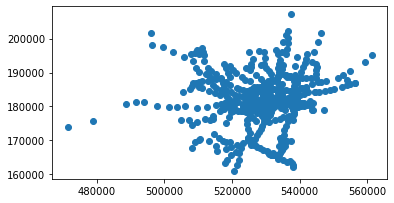

In [203]:
stations.plot()

In [204]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

In [205]:
import re
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

In [206]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

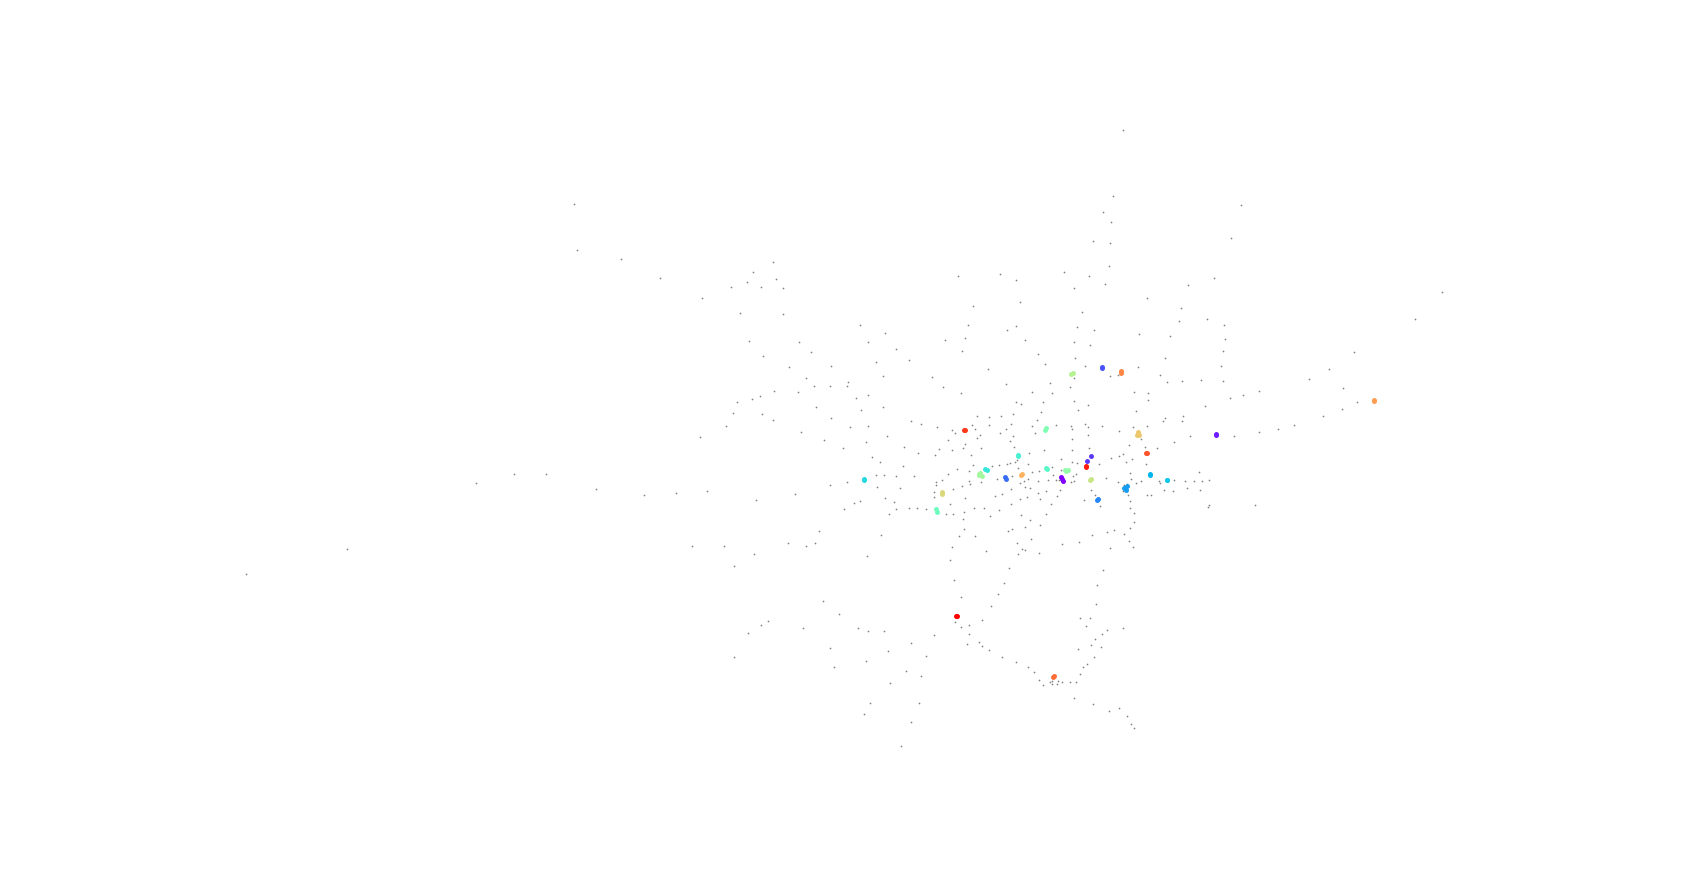

In [207]:
## we will plot all the stations with multiple points to check there are no errors
fig, ax = plt.subplots(figsize = (30,30))
# ax.set_aspect("equal")
ax.axis('off')
ax.margins(0.2)
color = iter(cm.rainbow(np.linspace(0, 1, 29)))
stations.plot(ax=ax, color='grey', markersize=0.5)
for i, group in stations.groupby('name'):
    if len(group)>1:
        group.plot(ax=ax, color = next(color), markersize=15)
plt.show()

In [208]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [209]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

<AxesSubplot:>

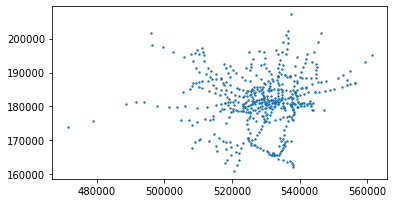

In [210]:
#check plot to make sure there are no errors
stations.plot(markersize=2)

In [211]:
lines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        701 non-null    object  
 1   lines     701 non-null    object  
 2   geometry  701 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 16.6+ KB


In [212]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['TfL Rail',
 'District',
 'Piccadilly',
 'Thameslink 6tph line',
 'Central',
 'Metropolitan',
 'Circle',
 'Victoria',
 'DLR',
 'London Overground',
 'Northern',
 'Hammersmith & City',
 'Emirates Air Line',
 'Tramlink',
 'Crossrail',
 'Crossrail 2',
 'East London',
 'Jubilee',
 'Waterloo & City',
 'Bakerloo']

In [213]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [214]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

TfL Rail


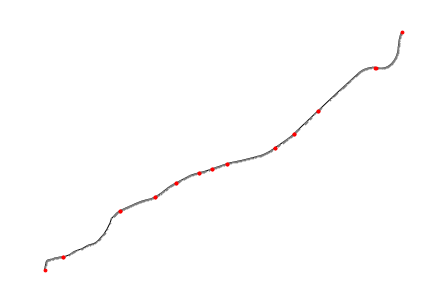

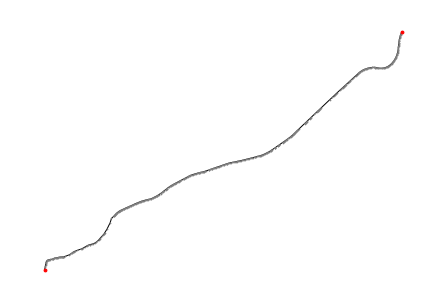

1
District


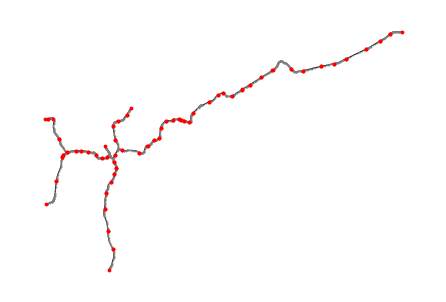

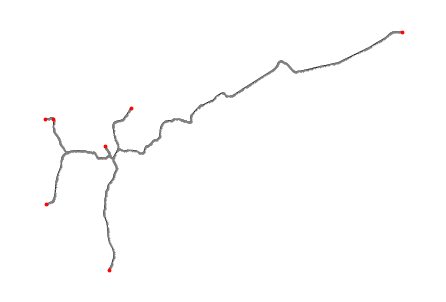

1
Piccadilly


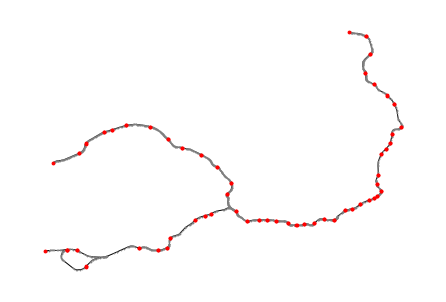

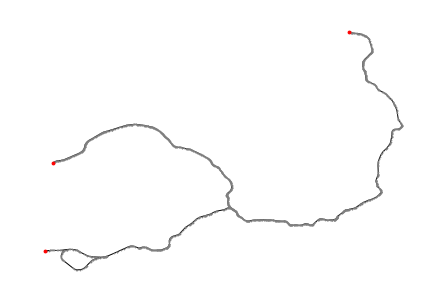

1
Central


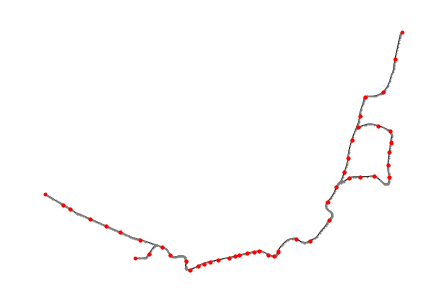

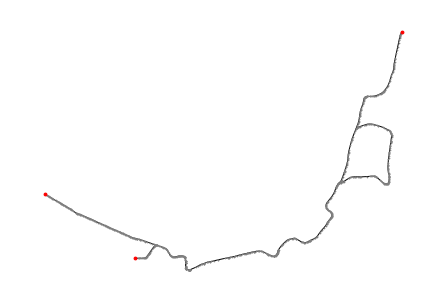

1
Metropolitan


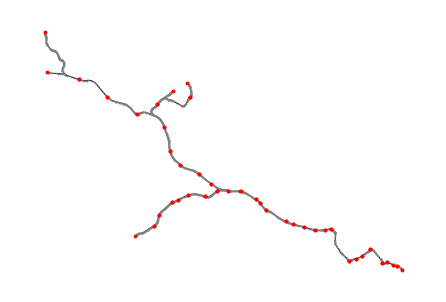

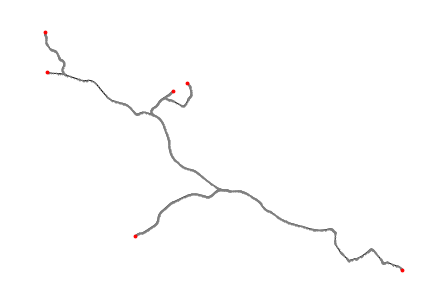

1
Circle


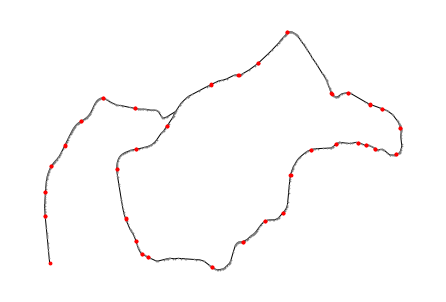

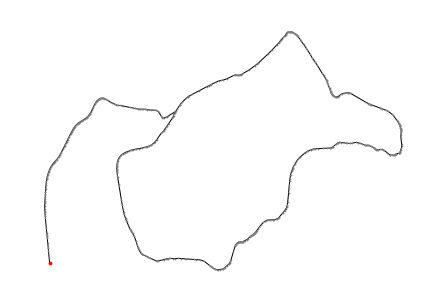

1
Victoria


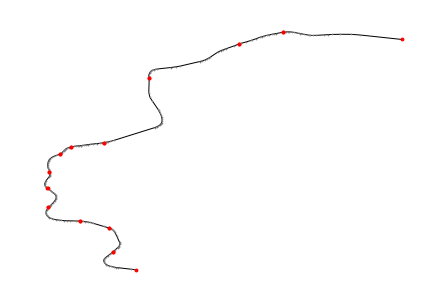

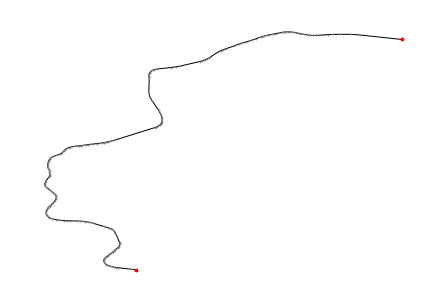

1
DLR


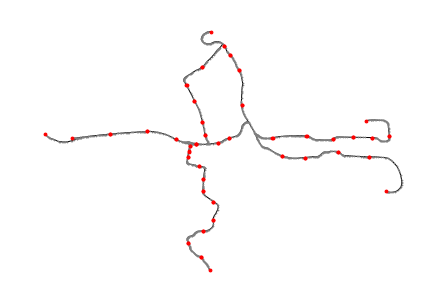

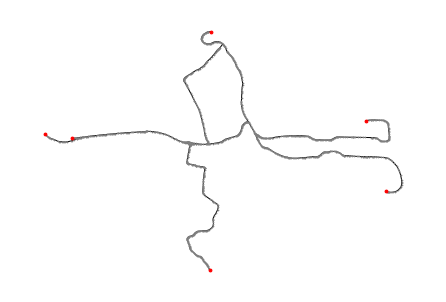

1
London Overground


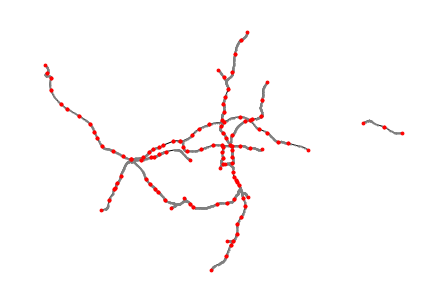

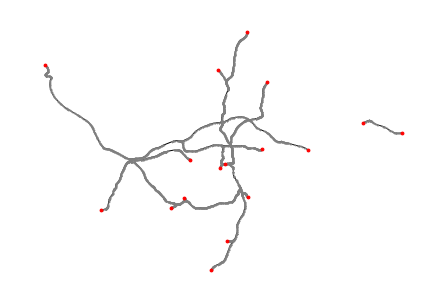

3
Northern


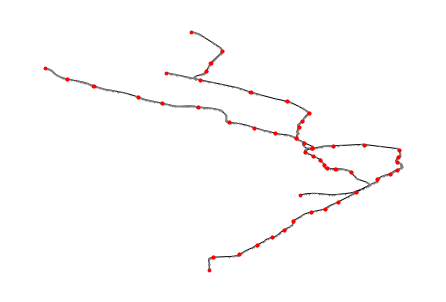

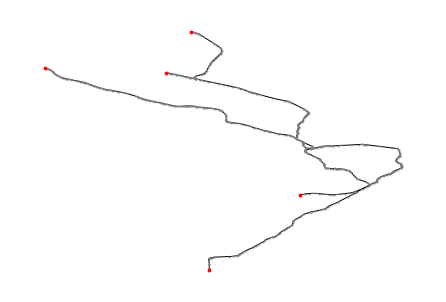

1
Hammersmith & City


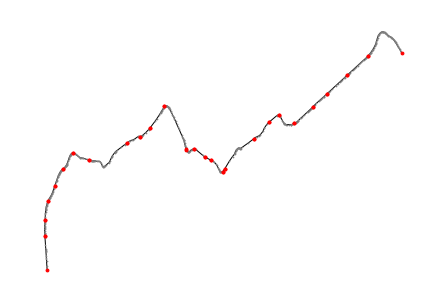

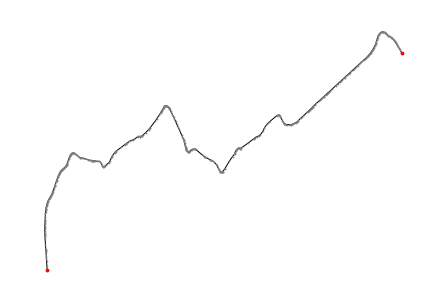

1
Jubilee


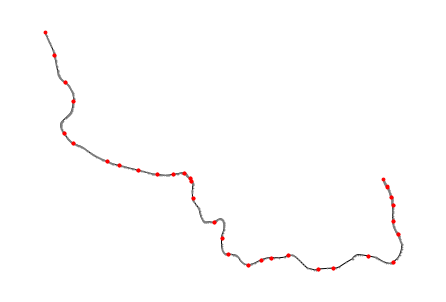

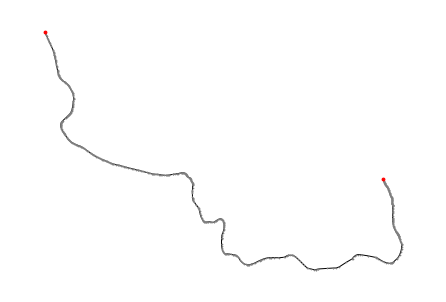

1
Waterloo & City


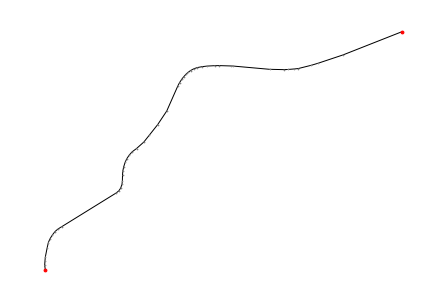

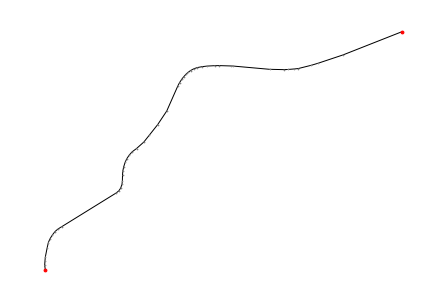

1
Bakerloo


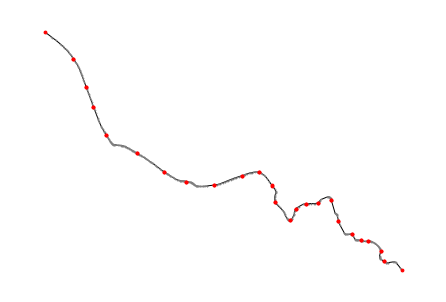

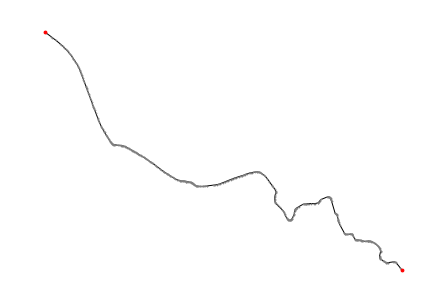

1


In [215]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G

In [216]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

,line_name,start_id,end_id,geometry
0,TfL Rail,910GLIVST,910GSTFD,"LINESTRING (533125.962 181621.108, 538522.880 ..."
1,TfL Rail,910GSTFD,910GLIVST,"LINESTRING (538522.880 184373.097, 533125.962 ..."
2,TfL Rail,910GSTFD,910GMRYLAND,"LINESTRING (538522.880 184373.097, 539209.340 ..."
3,TfL Rail,910GMRYLAND,910GFRSTGT,"LINESTRING (539209.340 184940.793, 540439.735 ..."
4,TfL Rail,910GMANRPK,910GILFORD,"LINESTRING (541932.419 185711.776, 543584.847 ..."


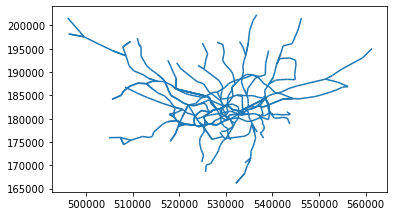

In [217]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

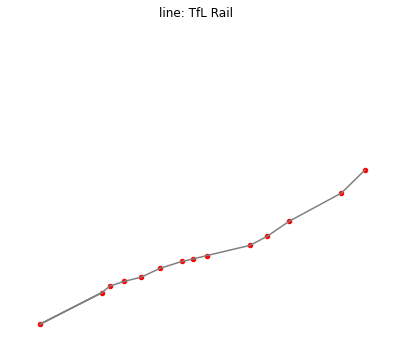

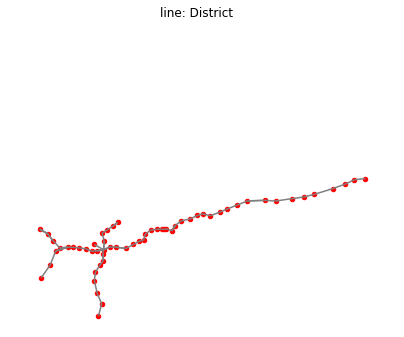

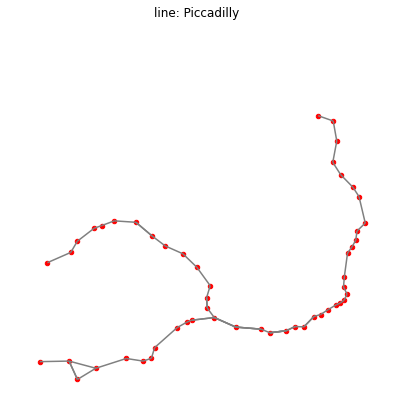

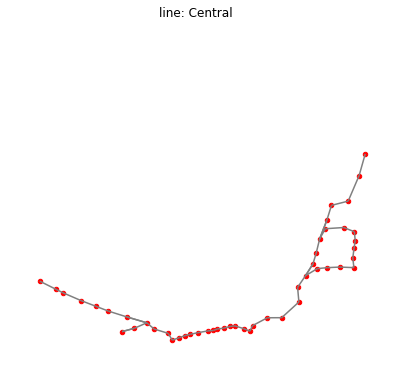

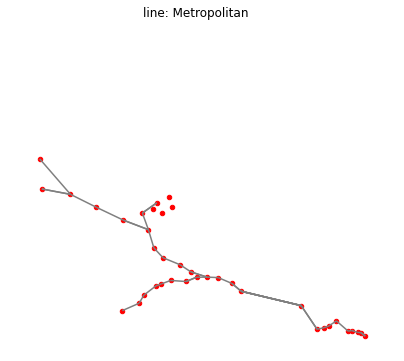

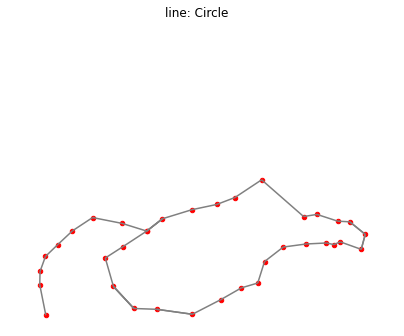

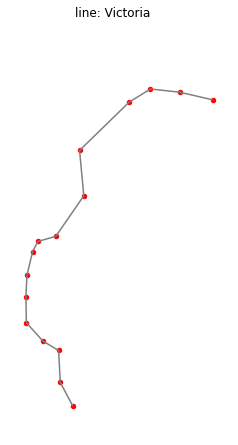

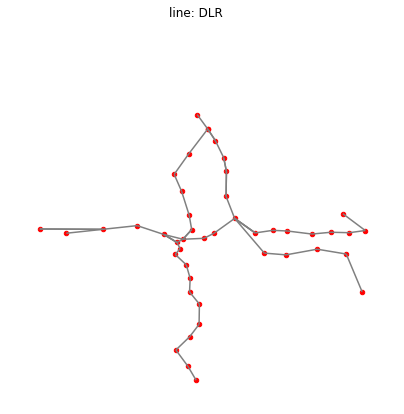

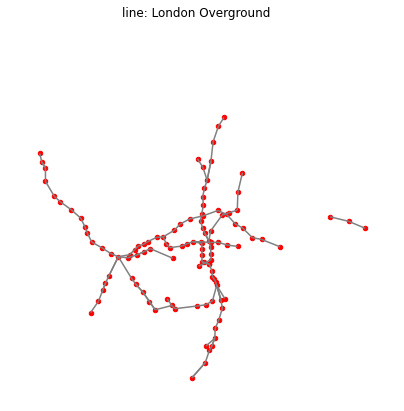

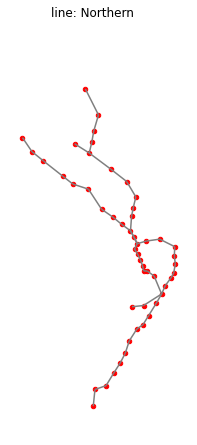

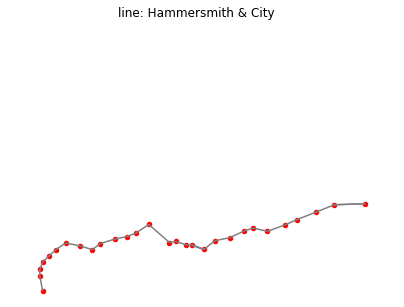

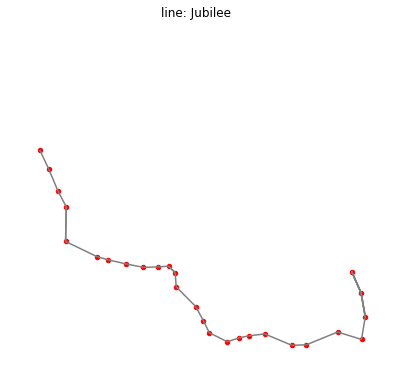

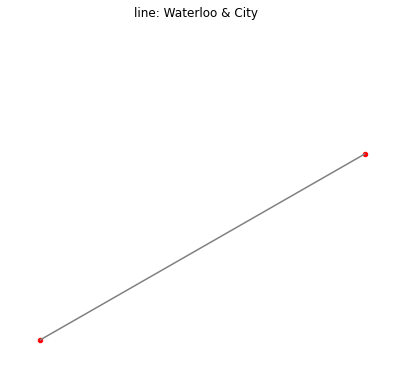

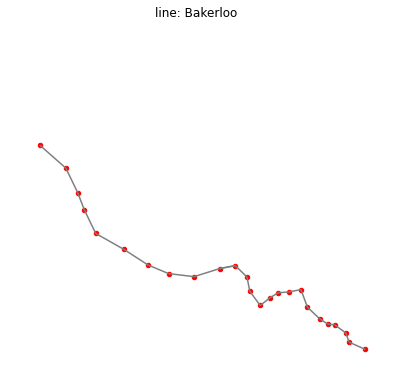

In [218]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

<AxesSubplot:>

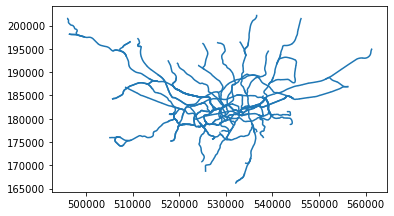

In [219]:
#plot to sanity check
edge_gdf.plot()

In [220]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [221]:
#let's replace the ids with the actual nane
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [222]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [223]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

In [224]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

In [225]:
#if want to know what is the maximum distance between stations
max(dict(G.edges).items(), key=lambda x: x[1]['length'])

(('Wembley Park', 'Finchley Road'),
 {'length': 7266.25825932972, 'line_name': 'Metropolitan'})

In [331]:
flows_job50['change_job_pro'] = flows_job50['change_job'] / (flows_job50['flows'] +1)

In [332]:
flows_job50

,station_origin,station_destination,flows,population,jobs,distance,log_dist,log_population,log_jobs,prodsimfitted1,...,alpha_i,jobs_half,prodsimfitted2,Ai1,A_i,prodsimfitted3,A_i2,prodsimfitted4,change_job,change_job_pro
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003505,6.395278,11.271478,131.0,...,-2.857836,78549,2155.0,37548.417547,0.000007,164.0,0.000008,180.0,180.0,180.000000
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049013,6.395278,6.091333,2.0,...,-2.857836,442,33.0,568.632753,0.000007,2.0,0.000008,3.0,2.0,1.000000
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236277,6.395278,6.499802,3.0,...,-2.857836,665,40.0,697.684015,0.000007,3.0,0.000008,3.0,0.0,0.000000
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534350,6.395278,10.981421,111.0,...,-2.857836,29386,903.0,15736.826368,0.000007,121.0,0.000008,75.0,74.0,37.000000
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709278,6.395278,9.643940,43.0,...,-2.857836,15428,471.0,8211.825518,0.000007,36.0,0.000008,39.0,2.0,0.052632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795550,9.503145,8.973606,8.114328,140.0,...,-0.152205,3342,2700.0,3143.310497,0.000006,151.0,0.000007,164.0,37.0,0.289062
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071247,8.973606,8.610139,224.0,...,-0.152205,5487,3772.0,4392.146925,0.000006,211.0,0.000007,230.0,-378.0,-0.620690
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162906,8.973606,5.991490,26.0,...,-0.152205,400,458.0,533.817202,0.000006,26.0,0.000007,28.0,22.0,3.142857
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585834,8.973606,6.794598,56.0,...,-0.152205,893,803.0,935.431759,0.000006,45.0,0.000007,49.0,-32.0,-0.390244


In [333]:
#check that our OD data and network data match
OD_names = set(flows_job50.station_origin.unique())
network_names = set([n for n in G.nodes()])

In [334]:
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Nine Elms', 'Battersea Power Station']

In [335]:
flows_job50_1 = flows_job50[~flows_job50.station_origin.isin(_filter)]
flows_job50_1 = flows_job50[~flows_job50.station_destination.isin(_filter)]

In [336]:
##### !!! add flow data
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [337]:
#calculate shortest paths for all flows and add data to dict
for i, row in flows_job50.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.change_job_pro
        except:
            flows[(v,u)] += row.change_job_pro

In [338]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

In [339]:
#check and you can find the change_A is already in your network!
max(dict(G.edges).items(), key=lambda x: x[1]['length'])

(('Wembley Park', 'Finchley Road'),
 {'length': 7266.25825932972,
  'line_name': 'Metropolitan',
  'flows': 26913.256066970032})

In [340]:
flows

{('Liverpool Street', 'Stratford'): 53791.70104614861,
 ('Liverpool Street', 'Bank and Monument'): 33731.871480456124,
 ('Liverpool Street', 'Bethnal Green'): 10006.069106683739,
 ('Liverpool Street', 'Aldgate'): 1381.9067186162636,
 ('Liverpool Street', 'Moorgate'): 22021.946399747103,
 ('Liverpool Street', 'Aldgate East'): 3405.001114100177,
 ('Stratford', 'Maryland'): 2578.967350224453,
 ('Stratford', 'Mile End'): 1100.9628463182275,
 ('Stratford', 'Leyton'): 15180.372503266075,
 ('Stratford', 'Stratford High Street'): 364.6700668130304,
 ('Stratford', 'Pudding Mill Lane'): 740.069104883698,
 ('Stratford', 'Stratford International'): 417.7116973507047,
 ('Stratford', 'Hackney Wick'): 3713.1937486410175,
 ('Stratford', 'West Ham'): 24782.976334197512,
 ('Maryland', 'Forest Gate'): 2605.8758251296704,
 ('Forest Gate', 'Manor Park'): 2664.519534450233,
 ('Manor Park', 'Ilford'): 2680.3049852370837,
 ('Ilford', 'Seven Kings'): 2695.308313124268,
 ('Seven Kings', 'Goodmayes'): 2718.95412

In [341]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

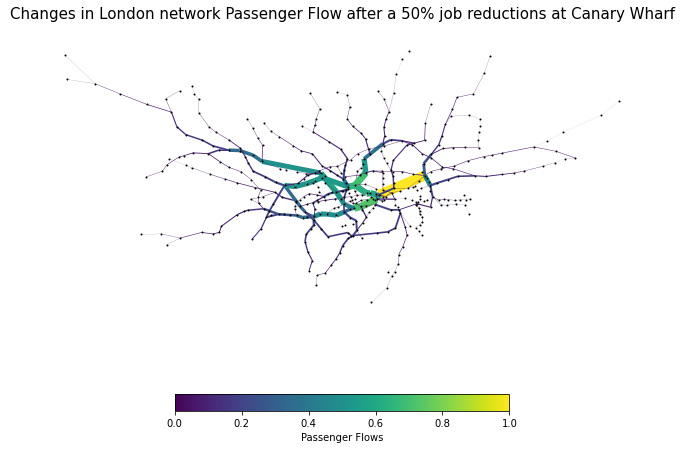

In [342]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,8))
#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)
nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Changes in London network Passenger Flow after a 50% job reductions at Canary Wharf",fontsize=15)
plt.show()

In [242]:
flows_4b_final['change_10'] = flows_4b_final['SIM_est_pow_tenth']-flows_4b_final['flows']
flows_4b_final['change_100'] = flows_4b_final['SIM_est_pow_hundred']-flows_4b_final['flows']

In [343]:
flows_4b_final['change_10_pro'] = flows_4b_final['change_10']/(flows_4b_final['flows'] + 1)
flows_4b_final['change_100_pro'] = flows_4b_final['change_100']/(flows_4b_final['flows'] + 1)

In [345]:
#check that our OD data and network data match
OD_names = set(flows_4b_final.station_origin.unique())
network_names = set([n for n in G.nodes()])

In [346]:
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Nine Elms', 'Battersea Power Station']

In [347]:
flows_4b_final_1 = flows_4b_final[~flows_4b_final.station_origin.isin(_filter)]
flows_4b_final_1 = flows_4b_final[~flows_4b_final.station_destination.isin(_filter)]

In [348]:
##### !!! add flow data
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [349]:
#calculate shortest paths for all flows and add data to dict
for i, row in flows_4b_final.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.change_10_pro
        except:
            flows[(v,u)] += row.change_10_pro

In [350]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

In [351]:
#check and you can find the change_A is already in your network!
max(dict(G.edges).items(), key=lambda x: x[1]['length'])

(('Wembley Park', 'Finchley Road'),
 {'length': 7266.25825932972,
  'line_name': 'Metropolitan',
  'flows': 19265.743208458804})

In [352]:
flows

{('Liverpool Street', 'Stratford'): 40565.77715070766,
 ('Liverpool Street', 'Bank and Monument'): 24961.89605185082,
 ('Liverpool Street', 'Bethnal Green'): 8247.33579844811,
 ('Liverpool Street', 'Aldgate'): 1240.4074686217757,
 ('Liverpool Street', 'Moorgate'): 16604.46387063492,
 ('Liverpool Street', 'Aldgate East'): 3108.459982871593,
 ('Stratford', 'Maryland'): 1909.333433023133,
 ('Stratford', 'Mile End'): 765.0621879229606,
 ('Stratford', 'Leyton'): 10297.983754653695,
 ('Stratford', 'Stratford High Street'): 438.402522529432,
 ('Stratford', 'Pudding Mill Lane'): 753.7667882672723,
 ('Stratford', 'Stratford International'): 601.6759645058248,
 ('Stratford', 'Hackney Wick'): 4132.472824821833,
 ('Stratford', 'West Ham'): 18642.2975762152,
 ('Maryland', 'Forest Gate'): 1950.4895663282484,
 ('Forest Gate', 'Manor Park'): 2037.767312599779,
 ('Manor Park', 'Ilford'): 2065.733176675778,
 ('Ilford', 'Seven Kings'): 2096.5539614763393,
 ('Seven Kings', 'Goodmayes'): 2140.364513600535,

In [353]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

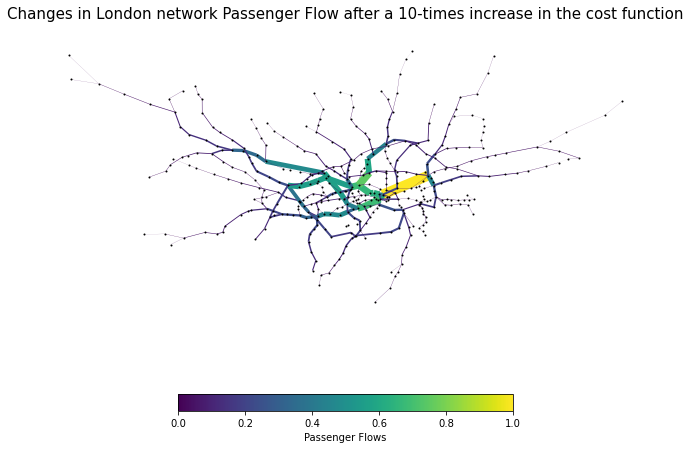

In [354]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,8))
#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)
nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Changes in London network Passenger Flow after a 10-times increase in the cost function",fontsize=15)
plt.show()

### change_100

In [355]:
#check that our OD data and network data match
OD_names = set(flows_4b_final.station_origin.unique())
network_names = set([n for n in G.nodes()])

In [356]:
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Nine Elms', 'Battersea Power Station']

In [357]:
flows_4b_final_1 = flows_4b_final[~flows_4b_final.station_origin.isin(_filter)]
flows_4b_final_1 = flows_4b_final[~flows_4b_final.station_destination.isin(_filter)]

In [358]:
##### !!! add flow data
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [359]:
#calculate shortest paths for all flows and add data to dict
for i, row in flows_4b_final.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.change_100_pro
        except:
            flows[(v,u)] += row.change_100_pro

In [360]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

In [361]:
#check and you can find the change_A is already in your network!
max(dict(G.edges).items(), key=lambda x: x[1]['length'])

(('Wembley Park', 'Finchley Road'),
 {'length': 7266.25825932972,
  'line_name': 'Metropolitan',
  'flows': 19242.592038166862})

In [362]:
flows

{('Liverpool Street', 'Stratford'): 40474.91761224537,
 ('Liverpool Street', 'Bank and Monument'): 24872.03785021098,
 ('Liverpool Street', 'Bethnal Green'): 8227.076638103897,
 ('Liverpool Street', 'Aldgate'): 1236.441197075894,
 ('Liverpool Street', 'Moorgate'): 16584.80151603592,
 ('Liverpool Street', 'Aldgate East'): 3106.0331479518018,
 ('Stratford', 'Maryland'): 1903.2356381034147,
 ('Stratford', 'Mile End'): 761.9008281716028,
 ('Stratford', 'Leyton'): 10307.340485867808,
 ('Stratford', 'Stratford High Street'): 433.74116296736366,
 ('Stratford', 'Pudding Mill Lane'): 750.5717404719385,
 ('Stratford', 'Stratford International'): 598.2572951286378,
 ('Stratford', 'Hackney Wick'): 4111.896715691497,
 ('Stratford', 'West Ham'): 18612.49456812523,
 ('Maryland', 'Forest Gate'): 1944.1294544599295,
 ('Forest Gate', 'Manor Park'): 2029.4978882816035,
 ('Manor Park', 'Ilford'): 2057.326036112363,
 ('Ilford', 'Seven Kings'): 2087.9833451704935,
 ('Seven Kings', 'Goodmayes'): 2132.4407410

In [363]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

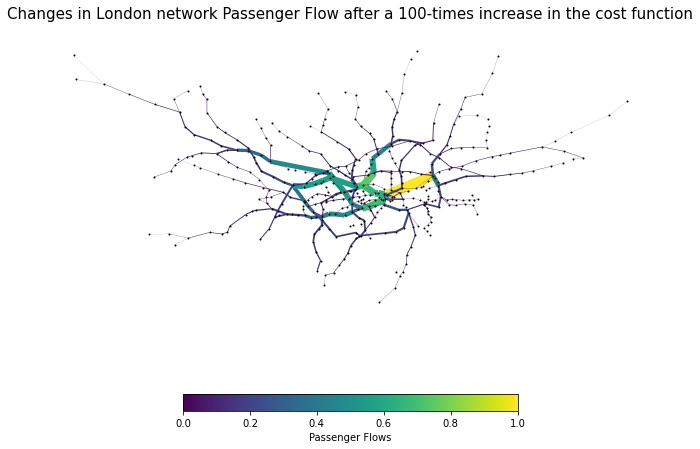

In [364]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,8))
#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)
nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Changes in London network Passenger Flow after a 100-times increase in the cost function",fontsize=15)
plt.show()

In [482]:
job = flows_job50.copy()
d_10 = flows_4b_final.copy()
d_100 = flows_4b_final.copy()

In [483]:
job = job[['station_origin','station_destination','change_job']]

In [484]:
job1 = job.sort_values(by=['change_job'],ascending=False).head(10)

In [485]:
job1

,station_origin,station_destination,change_job
31703,Lewisham,Bank and Monument,1484.0
11664,Clapham Junction,Stratford,1205.0
54874,Victoria,Stratford,1073.0
32306,Limehouse,Stratford,1037.0
31736,Lewisham,Stratford,1031.0
56154,Waterloo,Stratford,1015.0
54669,Victoria,Bank and Monument,990.0
56015,Waterloo,Farringdon,978.0
56044,Waterloo,Highbury & Islington,920.0
56175,Waterloo,Victoria,896.0


In [486]:
job2 = job.sort_values(by=['change_job']).tail(10)

In [487]:
job2

,station_origin,station_destination,change_job
56175,Waterloo,Victoria,896.0
56044,Waterloo,Highbury & Islington,920.0
56015,Waterloo,Farringdon,978.0
54669,Victoria,Bank and Monument,990.0
56154,Waterloo,Stratford,1015.0
31736,Lewisham,Stratford,1031.0
32306,Limehouse,Stratford,1037.0
54874,Victoria,Stratford,1073.0
11664,Clapham Junction,Stratford,1205.0
31703,Lewisham,Bank and Monument,1484.0


In [449]:
job1.to_csv('job1.csv')
job2.to_csv('job2.csv')

In [450]:
d_10 = d_10[['station_origin','station_destination','change_10']]

In [451]:
d_10_1 = d_10.sort_values(by=['change_10']).head(10)

In [452]:
d_10_2 = d_10.sort_values(by=['change_10']).tail(10)

In [453]:
d_10_2.to_csv('d_10_2.csv')
d_10_1.to_csv('d_10_1.csv')

In [454]:
d_100 = d_100[['station_origin','station_destination','change_100']]

In [455]:
d_100_1 = d_100.sort_values(by=['change_100']).head(10)

In [456]:
d_100_2 = d_100.sort_values(by=['change_100']).tail(10)

In [457]:
d_100_2.to_csv('d_100_2.csv')
d_100_1.to_csv('d_100_1.csv')